In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
from datetime import datetime
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

In [2]:

# Modules
from modules.connector import MyBigQuery, MySQL

In [3]:
bq = MyBigQuery(
    credentials_file="./credentials/New AutoMotive Index-487e031dc242.json"
)

In [4]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [5]:
this_month = datetime.today().strftime(format='%Y-%m')

In [6]:
datetime.today().month

5

In [7]:
last_month = datetime.today().replace(month=datetime.today().month-1).strftime(format='%Y-%m')

In [8]:
mandate =.22

In [9]:
car_targets = bq.from_bq_to_dataframe(
query = """
SELECT make, AVG(co2Emissions) as co2Target
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND monthOfFirstRegistration > '2020-12-31'
AND monthOfFirstRegistration < '2022-01-01'
AND co2Emissions > 0
GROUP BY make

""")

E0523 09:32:46.478784000 8680797696 client_channel.cc:673]             chand=0x7fb8d02056e0: Illegal keepalive throttling value 
E0523 09:32:46.478815000 8680797696 client_channel.cc:673]             chand=0x7fb8d02056e0: Illegal keepalive throttling value 
E0523 09:32:46.478819000 8680797696 client_channel.cc:673]             chand=0x7fb8d02056e0: Illegal keepalive throttling value 
E0523 09:32:46.478822000 8680797696 client_channel.cc:673]             chand=0x7fb8d02056e0: Illegal keepalive throttling value 
E0523 09:32:46.478825000 8680797696 client_channel.cc:673]             chand=0x7fb8d02056e0: Illegal keepalive throttling value 
E0523 09:32:46.478827000 8680797696 client_channel.cc:673]             chand=0x7fb8d02056e0: Illegal keepalive throttling value 
E0523 09:32:46.478830000 8680797696 client_channel.cc:673]             chand=0x7fb8d02056e0: Illegal keepalive throttling value 
E0523 09:32:46.478835000 8680797696 client_channel.cc:673]             chand=0x7fb8d02056e0: Ille

In [10]:
# %%bigquery car_targets --project rugged-baton-283921
# SELECT make, AVG(co2Emissions) as co2Target
# FROM VES_dataset.VRN_UK
# WHERE typeApproval = 'M1'
# AND monthOfFirstRegistration > '2020-12-31'
# AND monthOfFirstRegistration < '2022-01-01'
# AND co2Emissions > 0
# GROUP BY make

In [11]:
df_activity = bq.from_bq_to_dataframe(
query = """
SELECT 
    make, 
    COUNT(*) as totalSales,
    COUNTIF(co2Emissions > 0) as nonzevSales,
    COUNTIF(co2Emissions = 0) as zevSales,
    SUM(co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)
GROUP BY make
ORDER BY totalSales ASC;
"""
)

E0523 09:32:48.765925000 8680797696 client_channel.cc:673]             chand=0x7fb8d031b1a0: Illegal keepalive throttling value 
E0523 09:32:48.765990000 8680797696 client_channel.cc:673]             chand=0x7fb8d031b1a0: Illegal keepalive throttling value 
E0523 09:32:48.766000000 8680797696 client_channel.cc:673]             chand=0x7fb8d031b1a0: Illegal keepalive throttling value 
E0523 09:32:48.766009000 8680797696 client_channel.cc:673]             chand=0x7fb8d031b1a0: Illegal keepalive throttling value 
E0523 09:32:48.766017000 8680797696 client_channel.cc:673]             chand=0x7fb8d031b1a0: Illegal keepalive throttling value 
E0523 09:32:48.766025000 8680797696 client_channel.cc:673]             chand=0x7fb8d031b1a0: Illegal keepalive throttling value 
E0523 09:32:48.766033000 8680797696 client_channel.cc:673]             chand=0x7fb8d031b1a0: Illegal keepalive throttling value 
E0523 09:32:48.766042000 8680797696 client_channel.cc:673]             chand=0x7fb8d031b1a0: Ille

In [12]:
# %%bigquery df_activity --project rugged-baton-283921
# SELECT 
#     make, 
#     COUNT(*) as totalSales,
#     COUNTIF(co2Emissions > 0) as nonzevSales,
#     COUNTIF(co2Emissions = 0) as zevSales,
#     SUM(co2Emissions) as co2Activity

# FROM VES_dataset.VRN_UK
# WHERE typeApproval = 'M1'
# AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
# AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
#     AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
#     -- AND total > 2500
#     GROUP BY make
#     HAVING COUNT(*) > 2500
# )
# GROUP BY make
# ORDER BY totalSales ASC;

In [13]:
dfa = df_activity.merge(car_targets, how='left', on='make')
dfa['co2Allowances'] = dfa.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
dfa['co2Compliance'] = dfa.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [14]:

# co2ComplianceAdj will be the surplus after removing demand from other manufacturers
def co2ComplainceAdjFunc(row, total_trading_diff_perc):
    #checks for nan
    if row.co2Compliance > 0:
        co2ComplianceAdj = row.co2Compliance * total_trading_diff_perc
    
        return co2ComplianceAdj
    else:
        return row.co2Compliance


    
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    
    if new_zev_credits > 0:
        return new_zev_credits
    else:
        return 0

    

        
# def proposed_co2_to_zev(row, mandate):
#     new_zev_credits = 0
#     limit = mandate*.25
#     limit = limit * row.totalSales
    
#     conversion_factor = row.co2Target
    
#     if row.co2Compliance > 0:
#         new_zev_credits = row.co2Compliance / conversion_factor
    
#     if new_zev_credits > limit:
#         new_zev_credits = limit
        
#     return new_zev_credits




In [15]:
# Adjust CO2 -> ZEV transfers to take into account demand from non-compliant manufacturers. 

co2_trading_demand = dfa[dfa.co2Compliance < 0].co2Compliance.sum()
co2_trading_supply = dfa[dfa.co2Compliance > 0].co2Compliance.sum()

co2_trading_diff = co2_trading_supply + co2_trading_demand
co2_trading_diff_perc = co2_trading_diff / co2_trading_supply

In [16]:
dfa['co2ComplianceAdj'] = dfa.apply(lambda row: co2ComplainceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)

In [17]:
mandate = .22
dfa['ZEVMallowances'] = dfa.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
dfa['ZEV Surplus'] = dfa.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)

In [18]:
dfa['co2_to_mandate_allowances'] = dfa.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# dfa['proposed_co2_to_mandate_allowances'] = dfa.apply(lambda row: proposed_co2_to_zev(row, mandate=mandate), axis=1)


In [19]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,ZEVMallowances,ZEV Surplus,co2_to_mandate_allowances
0,JEEP,2677,2677,0,273090.0,163.147143,4.367449e+05,163654.901429,89542.979640,2088.06,-588.94,147.235000
1,DS,3673,3000,673,332578.0,123.471191,3.704136e+05,37835.572343,20701.548529,2864.94,-135.06,123.961368
2,LEXUS,8835,8373,462,1001276.0,150.771893,1.262413e+06,261137.061501,142879.867190,6891.30,-1481.70,485.925000
3,JAGUAR,9971,6116,3855,987936.0,174.377334,1.066492e+06,78555.774896,42981.408383,7777.38,1661.38,257.373703
4,POLESTAR,10043,2,10041,26.0,192.000000,3.840000e+02,358.000000,195.877951,7833.54,7831.54,1.172922
5,PORSCHE,14845,10766,4079,2321349.0,219.344014,2.361458e+06,40108.656668,21945.255510,11579.10,813.10,131.408716
6,CUPRA,17497,11647,5850,1783864.0,118.189238,1.376550e+06,-407313.944522,-407313.944522,13647.66,2000.66,0.000000
7,SUZUKI,17585,17585,0,2069009.0,117.626612,2.068464e+06,-545.023529,-545.023529,13716.30,-3868.70,0.000000
8,HONDA,21588,21273,315,2593297.0,124.830257,2.655514e+06,62217.058706,34041.759656,16838.64,-4434.36,203.842872
9,FIAT,22007,16609,5398,2072593.0,130.535102,2.168058e+06,95464.503635,52232.936690,17165.46,556.46,312.772076


In [23]:

dfa['ZEV Surplus after CO2'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# dfa['ZEV Surplus after CO2 - Proposed'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [26]:
dfa[(dfa.co2Compliance < 0) & (dfa['ZEV Surplus'] > 0)]

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2
6,CUPRA,17497,11647,5850,1783864.0,118.189238,1.376550e+06,-407313.944522,-407313.944522,0.0,13647.66,2000.66,2000.66
21,MG,56668,35502,21166,5493667.0,149.970316,5.324246e+06,-169420.838740,-169420.838740,0.0,44201.04,8699.04,8699.04


In [8]:
dfa[dfa.make == 'VOLKSWAGEN']

NameError: name 'dfa' is not defined

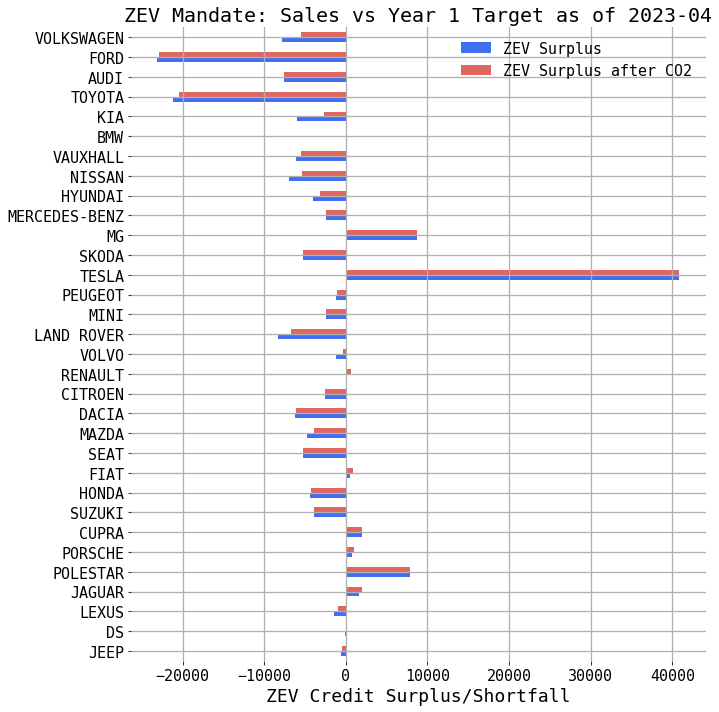

In [22]:
fig, ax = plt.subplots()

dfa.plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('ZEV Mandate: Sales vs Year 1 Target as of {}'.format(last_month))

plt.savefig('plots/top_20_last_12_months_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, facecolor='white')
plt.show()

In [23]:
# fig, ax = plt.subplots()

# dfa.plot(x='make', y=[
#     'ZEV Surplus', 
#     'ZEV Surplus after CO2', 
#     # 'ZEV Surplus after CO2 - Proposed'
# ], kind='barh', ax=ax, figsize=(10, 10))
# ax.set_xlabel('ZEV Credit Surplus/Shortfall')
# ax.set_ylabel('')

# ax.set_title('How close are manufacturers to reaching compliance')

# plt.savefig('plots/top_20_last_12_months.png', transparent=False, bbox_inches='tight', dpi=300)
# plt.show()

In [24]:
dfa['CO2 Performance'] = dfa.co2Activity / dfa.nonzevSales

In [25]:
dfa_sel = dfa[[
    'make',
    'totalSales',
    'nonzevSales',
    'zevSales',
    'co2Target',
    'CO2 Performance',
    'ZEVMallowances',
    'ZEV Surplus',
    'ZEV Surplus after CO2'
]].rename(columns={
    'make': 'Make',
    'totalSales': 'Total Sales',
    'co2Target': 'CO2 Target',
    'nonzevSales': 'Non-ZEV Sales',
    'zevSales': 'ZEV Sales',
    'ZEVMallowances': 'Allocated allowances',
    'ZEV Surplus': 'Allowance Surplus',
    'ZEV Surplus after CO2': 'Allowance Surplus (after CO2 transfers)'
})

# dfa_sel['Mean CO2'] = 
dfa_sel = round(dfa_sel, ndigits=2)

dfa_sel = dfa_sel.sort_values('Total Sales', ascending=False)

In [26]:
dfa_sel.to_csv('ZEV_compliance_tracker.csv')

In [27]:
dfa_sel

,Make,Total Sales,Non-ZEV Sales,ZEV Sales,CO2 Target,CO2 Performance,Allocated allowances,Allowance Surplus,Allowance Surplus (after CO2 transfers)
31,VOLKSWAGEN,143625,119894,23731,139.81,133.74,112027.50,-7866.50,-5481.00
30,FORD,126691,121917,4774,127.00,126.52,98818.98,-23098.02,-22906.29
29,AUDI,106173,90414,15759,142.00,146.84,82814.94,-7599.06,-7599.06
28,TOYOTA,99037,98379,658,110.47,108.41,77248.86,-21130.14,-20464.60
27,KIA,94702,79825,14877,135.70,123.17,73867.56,-5957.44,-2681.38
26,BMW,92528,72179,20349,130.08,134.38,72171.84,-7.16,-7.16
25,VAUXHALL,81268,69511,11756,127.64,124.93,63389.04,-6121.96,-5506.21
24,NISSAN,81102,70237,10865,142.63,135.46,63259.56,-6977.44,-5326.03
23,HYUNDAI,79795,66292,13503,127.24,123.16,62240.10,-4051.90,-3167.51
22,MERCEDES-BENZ,71567,58247,13320,137.09,146.23,55822.26,-2424.74,-2424.74


# Rolling Performance

In [28]:
%%bigquery df_act --project rugged-baton-283921
SELECT 
    VES.make,
    VES.monthOfFirstRegistration,
    COUNT(*) as totalSales,
    COUNTIF(VES.co2Emissions > 0) as nonzevSales,
    COUNTIF(VES.co2Emissions = 0) as zevSales,
    SUM(VES.co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK VES
WHERE typeApproval = 'M1'
AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND monthOfFirstRegistration > '2020-03-31'
#     AND monthOfFirstRegistration < '2023-04-01'
#     GROUP BY make
#     ORDER BY COUNT(*) DESC
#     LIMIT 20
    
# )

# Volume limit
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)



GROUP BY make, monthofFirstRegistration
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 1173/1173 [00:00<00:00, 1513.86rows/s]


In [29]:
# If we want to filter out all but the top five/ten/twenty makes, we can use this
top_makes = df_act.groupby('make').sum().sort_values('totalSales', ascending=False).index.tolist()[:10]

In [30]:
# Make a copy to edit
df = df_act.copy()#.merge(car_targets, how='left', on='make')

In [31]:
df.head()

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,DS,2020-04-01 00:00:00+00:00,1,0,1,0.0
1,TESLA,2022-07-01 00:00:00+00:00,2,0,2,0.0
2,SUZUKI,2020-04-01 00:00:00+00:00,5,5,0,613.0
3,JEEP,2020-04-01 00:00:00+00:00,6,6,0,1397.0
4,TESLA,2021-07-01 00:00:00+00:00,8,0,8,0.0


In [32]:
# This turns our numbers into 12 month rolling totals/averages

dfs = []
makes = df.make.unique().tolist()

for make in makes:
    temp_df = df[df.make == make].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
df = pd.concat(dfs)

In [33]:
# This gives us the targets for CO2 performance
df = df.reset_index().merge(car_targets, how='left', on='make')

In [34]:
df['co2Allowances'] = df.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
df['co2Compliance'] = df.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [35]:
tdf = df[df.monthOfFirstRegistration == '2022-03-01']

tdf[tdf.co2Compliance < 0].co2Compliance.sum()

-49707.34978625737

In [36]:
(co2_trading_supply + co2_trading_demand) / co2_trading_supply

0.5471451136402419

In [37]:
dfs = []

months = list(df.monthOfFirstRegistration.unique())

for month in months:
    tdf = df[df.monthOfFirstRegistration == month]
    co2_trading_demand = tdf[tdf.co2Compliance < 0].co2Compliance.sum()
    co2_trading_supply = tdf[tdf.co2Compliance > 0].co2Compliance.sum()

    co2_trading_diff = co2_trading_supply + co2_trading_demand
    co2_trading_diff_perc = co2_trading_diff / co2_trading_supply
    
    tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplainceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
    
    dfs.append(tdf)

<ipython-input-37-81377712ce43>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplainceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-37-81377712ce43>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplainceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-37-81377712ce43>:13: SettingWithCopyWarning: 
A value is tryi

In [38]:
df = pd.concat(dfs)

In [39]:
df['co2_to_mandate_allowances'] = df.apply(lambda row: co2_to_zev(row, mandate=.22), axis=1)

In [40]:
mandate = .22
df['ZEVMallowances'] = df.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
df['ZEV Surplus'] = df.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
df['ZEV Surplus after CO2'] = df.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# df['ZEV Surplus after CO2 - Proposed'] = df.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [41]:
# Calculate effective target

dfs = []

months = list(df.monthOfFirstRegistration.unique())

for month in months:
    tdf = df[df.monthOfFirstRegistration == month]
    
    tdf['implied_target'] = 1 - ((tdf.groupby(['monthOfFirstRegistration']).sum()['ZEVMallowances'] + (tdf.groupby(['monthOfFirstRegistration']).sum()['co2_to_mandate_allowances'])) / tdf.groupby(['monthOfFirstRegistration']).sum()['totalSales'])
    dfs.append(tdf)

<ipython-input-41-d2797a4f042e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['implied_target'] = 1 - ((tdf.groupby(['monthOfFirstRegistration']).sum()['ZEVMallowances'] + (tdf.groupby(['monthOfFirstRegistration']).sum()['co2_to_mandate_allowances'])) / tdf.groupby(['monthOfFirstRegistration']).sum()['totalSales'])


<AxesSubplot:xlabel='monthOfFirstRegistration'>

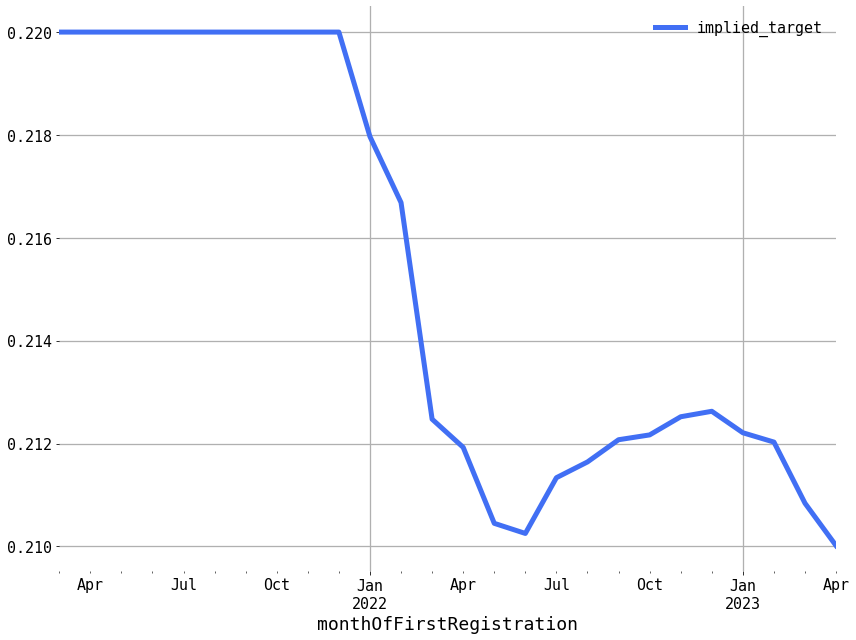

In [42]:
# Implied targets

# We consider the additional Co2 -> zev credits and figure out what implied % target results from this flexibility
imtg = 1 - ((df.groupby(['monthOfFirstRegistration']).sum()['ZEVMallowances'] + (df.groupby(['monthOfFirstRegistration']).sum()['co2_to_mandate_allowances'])) / df.groupby(['monthOfFirstRegistration']).sum()['totalSales'])
imtg = imtg.to_frame(name='implied_target')
imtg.plot()

<AxesSubplot:xlabel='monthOfFirstRegistration'>

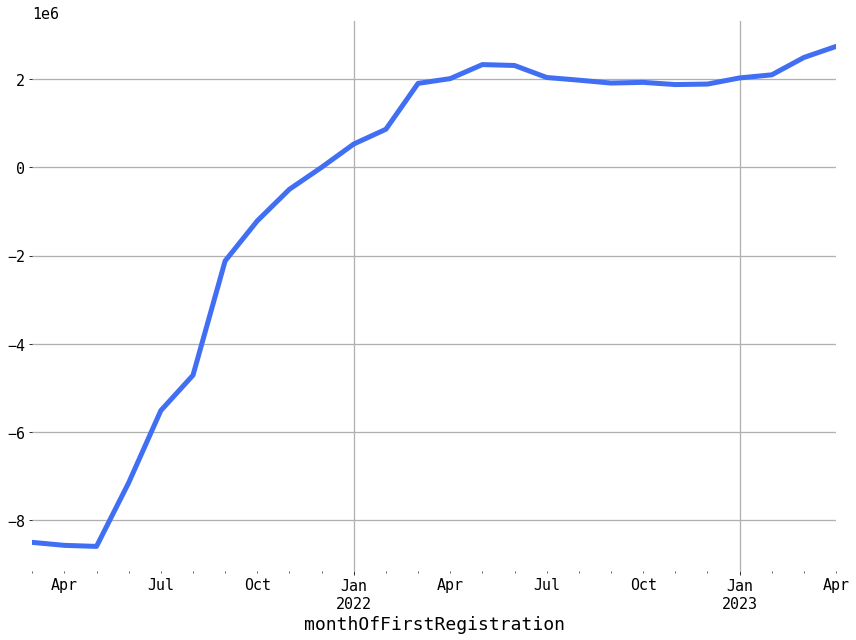

In [43]:
df.groupby(['monthOfFirstRegistration']).sum().co2Compliance.plot()

In [44]:
# Are there any manufacturers failing to make Co2 compliance but with surplus ZEV credits, who would need to transfer ZEV credits into the regime 
# We assume that manufacturers would rather transfer from CO2 than purchase CO2 allowances. 
# df[(df['ZEV Surplus'] > 0) & (df.co2Compliance < 0)]

In [45]:
df[df.monthOfFirstRegistration == '2023-04-01']

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2
25,36,2023-04-01 00:00:00+00:00,3673.0,3000.0,673.0,332578.0,DS,123.471191,3.704136e+05,37835.572343,20701.548529,123.961368,2864.94,-135.06,-11.098632
51,36,2023-04-01 00:00:00+00:00,52404.0,0.0,52404.0,0.0,TESLA,NaN,NaN,NaN,NaN,0.000000,40875.12,40875.12,40875.120000
77,36,2023-04-01 00:00:00+00:00,17585.0,17585.0,0.0,2069009.0,SUZUKI,117.626612,2.068464e+06,-545.023529,-545.023529,0.000000,13716.30,-3868.70,-3868.700000
103,36,2023-04-01 00:00:00+00:00,2677.0,2677.0,0.0,273090.0,JEEP,163.147143,4.367449e+05,163654.901429,89542.979640,147.235000,2088.06,-588.94,-441.705000
129,36,2023-04-01 00:00:00+00:00,99037.0,98379.0,658.0,10664823.0,TOYOTA,110.470319,1.086796e+07,203136.471672,111145.127877,665.539688,77248.86,-21130.14,-20464.600312
155,36,2023-04-01 00:00:00+00:00,24655.0,23947.0,708.0,3076600.0,MAZDA,138.966062,3.327820e+06,251220.277103,137453.947064,823.077527,19230.90,-4716.10,-3893.022473
178,33,2023-04-01 00:00:00+00:00,10043.0,2.0,10041.0,26.0,POLESTAR,192.000000,3.840000e+02,358.000000,195.877951,1.172922,7833.54,7831.54,7832.712922
204,36,2023-04-01 00:00:00+00:00,21588.0,21273.0,315.0,2593297.0,HONDA,124.830257,2.655514e+06,62217.058706,34041.759656,203.842872,16838.64,-4434.36,-4230.517128
230,36,2023-04-01 00:00:00+00:00,28431.0,28431.0,0.0,3762806.0,DACIA,134.543628,3.825210e+06,62403.880320,34143.978189,204.454959,22176.18,-6254.82,-6050.365041
256,36,2023-04-01 00:00:00+00:00,14845.0,10766.0,4079.0,2321349.0,PORSCHE,219.344014,2.361458e+06,40108.656668,21945.255510,131.408716,11579.10,813.10,944.508716


Text(0.5, 1.0, 'ZEV Mandate: Sales vs Year 1 Target as of 2023-04')

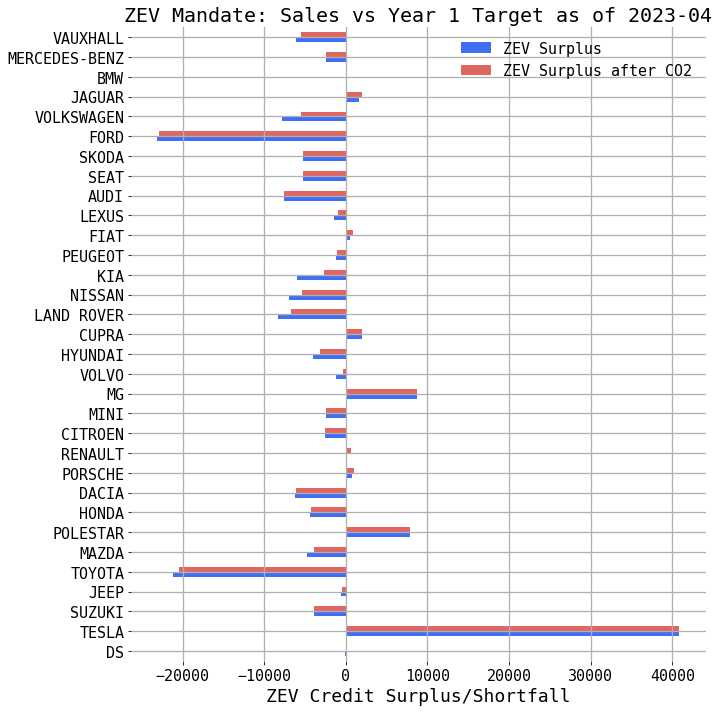

In [46]:
fig, ax = plt.subplots()

df[df.monthOfFirstRegistration == '2023-04-01'].plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('ZEV Mandate: Sales vs Year 1 Target as of {}'.format(last_month))

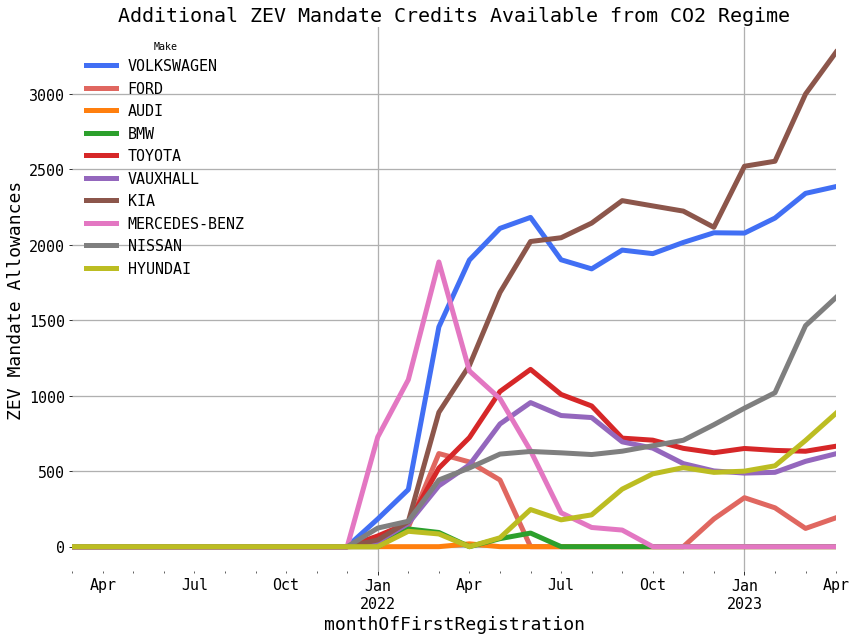

In [47]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.legend(title='Make', loc='upper left')
ax.set_title('Additional ZEV Mandate Credits Available from CO2 Regime')

plt.show()

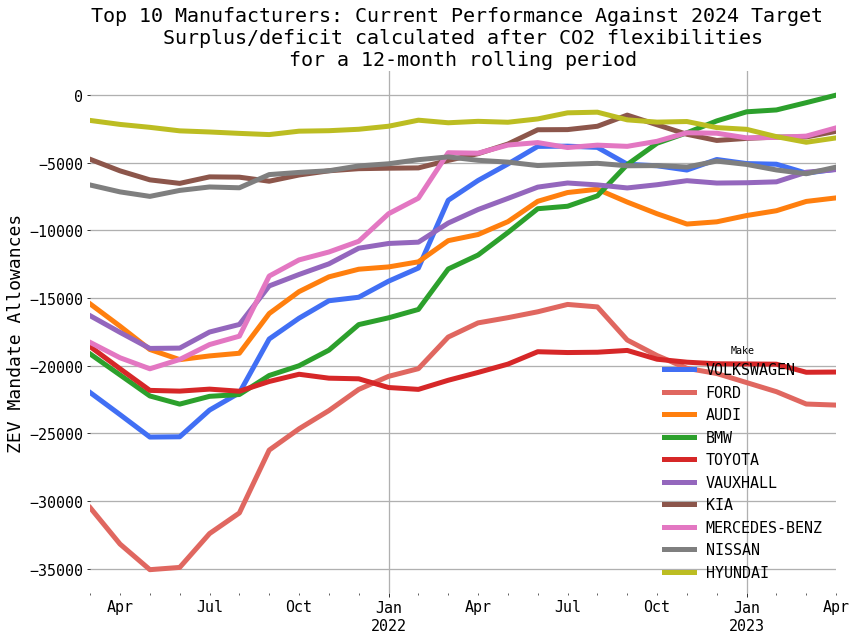

In [48]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='ZEV Surplus after CO2')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.set_xlabel('')
ax.set_title('Top 10 Manufacturers: Current Performance Against 2024 Target \n Surplus/deficit calculated after CO2 flexibilities \nfor a 12-month rolling period')
ax.legend(title='Make', loc='lower right')

plt.savefig('plots/top_10_manufacturers_zevm.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [49]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2,CO2 Performance
0,JEEP,2677,2677,0,273090.0,163.147143,4.367449e+05,163654.901429,89542.979640,147.235000,2088.06,-588.94,-441.705000,102.013448
1,DS,3673,3000,673,332578.0,123.471191,3.704136e+05,37835.572343,20701.548529,123.961368,2864.94,-135.06,-11.098632,110.859333
2,LEXUS,8835,8373,462,1001276.0,150.771893,1.262413e+06,261137.061501,142879.867190,485.925000,6891.30,-1481.70,-995.775000,119.583901
3,JAGUAR,9971,6116,3855,987936.0,174.377334,1.066492e+06,78555.774896,42981.408383,257.373703,7777.38,1661.38,1918.753703,161.533028
4,POLESTAR,10043,2,10041,26.0,192.000000,3.840000e+02,358.000000,195.877951,1.172922,7833.54,7831.54,7832.712922,13.000000
5,PORSCHE,14845,10766,4079,2321349.0,219.344014,2.361458e+06,40108.656668,21945.255510,131.408716,11579.10,813.10,944.508716,215.618521
6,CUPRA,17497,11647,5850,1783864.0,118.189238,1.376550e+06,-407313.944522,-407313.944522,0.000000,13647.66,2000.66,2000.660000,153.160814
7,SUZUKI,17585,17585,0,2069009.0,117.626612,2.068464e+06,-545.023529,-545.023529,0.000000,13716.30,-3868.70,-3868.700000,117.657606
8,HONDA,21588,21273,315,2593297.0,124.830257,2.655514e+06,62217.058706,34041.759656,203.842872,16838.64,-4434.36,-4230.517128,121.905561
9,FIAT,22007,16609,5398,2072593.0,130.535102,2.168058e+06,95464.503635,52232.936690,312.772076,17165.46,556.46,869.232076,124.787344


In [50]:
df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2']

monthOfFirstRegistration
2021-03-01 00:00:00+00:00   -208559.940000
2021-04-01 00:00:00+00:00   -231859.160000
2021-05-01 00:00:00+00:00   -249765.340000
2021-06-01 00:00:00+00:00   -245960.560000
2021-07-01 00:00:00+00:00   -232713.200000
2021-08-01 00:00:00+00:00   -226903.900000
2021-09-01 00:00:00+00:00   -191924.540000
2021-10-01 00:00:00+00:00   -179082.160000
2021-11-01 00:00:00+00:00   -168148.160000
2021-12-01 00:00:00+00:00   -157362.620000
2022-01-01 00:00:00+00:00   -150970.950160
2022-02-01 00:00:00+00:00   -143605.395988
2022-03-01 00:00:00+00:00   -110789.514013
2022-04-01 00:00:00+00:00   -101338.961428
2022-05-01 00:00:00+00:00    -90205.130733
2022-06-01 00:00:00+00:00    -77644.440447
2022-07-01 00:00:00+00:00    -75152.463298
2022-08-01 00:00:00+00:00    -73056.777016
2022-09-01 00:00:00+00:00    -70378.395407
2022-10-01 00:00:00+00:00    -72234.638921
2022-11-01 00:00:00+00:00    -70590.373923
2022-12-01 00:00:00+00:00    -60652.451896
2023-01-01 00:00:00+00:00    

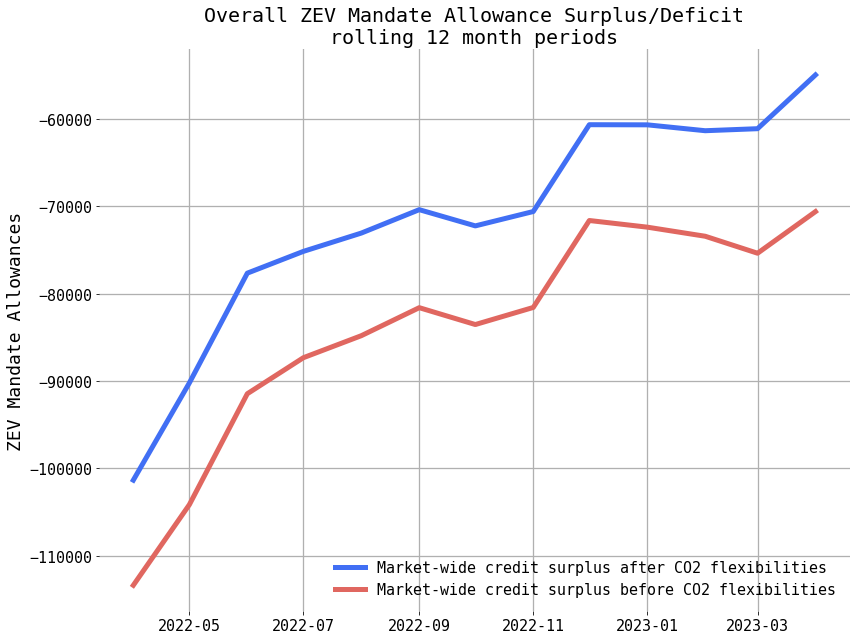

In [51]:
fig, ax = plt.subplots()

# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus'], label='Market-wide credit surplus')
plt_df = df.groupby('monthOfFirstRegistration').sum()[['ZEV Surplus after CO2', 'ZEV Surplus']]

ax.plot(plt_df[plt_df.index > '2022-03-01']['ZEV Surplus after CO2'], label='Market-wide credit surplus after CO2 flexibilities')
ax.plot(plt_df[plt_df.index > '2022-03-01']['ZEV Surplus'], label='Market-wide credit surplus before CO2 flexibilities')
# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2 - Proposed'], label='Proposed Market-wide credit surplus after CO2 flexibilities')
ax.set_ylabel('ZEV Mandate Allowances')

# ax.legend(loc='lower right')
ax.set_title('Overall ZEV Mandate Allowance Surplus/Deficit\nrolling 12 month periods')
ax.legend(loc='lower right')

plt.savefig('plots/aggregate_demand_credits_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [52]:
df

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2
0,11,2021-03-01 00:00:00+00:00,2069.0,1570.0,499.0,205680.0,DS,123.471191,1.938498e+05,-11830.230474,-11830.230474,0.000000,1613.82,43.82,43.820000
26,11,2021-03-01 00:00:00+00:00,25040.0,0.0,25040.0,0.0,TESLA,NaN,NaN,NaN,NaN,0.000000,19531.20,19531.20,19531.200000
52,11,2021-03-01 00:00:00+00:00,16650.0,16650.0,0.0,2046974.0,SUZUKI,117.626612,1.958483e+06,-88490.905985,-88490.905985,0.000000,12987.00,-3663.00,-3663.000000
78,11,2021-03-01 00:00:00+00:00,4225.0,4225.0,0.0,742153.0,JEEP,163.147143,6.892967e+05,-52856.321429,-52856.321429,0.000000,3295.50,-929.50,-929.500000
104,11,2021-03-01 00:00:00+00:00,84670.0,84629.0,41.0,9713758.0,TOYOTA,110.470319,9.348993e+06,-364765.408816,-364765.408816,0.000000,66042.60,-18586.40,-18586.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,36,2023-04-01 00:00:00+00:00,143625.0,119894.0,23731.0,16034214.0,VOLKSWAGEN,139.809492,1.676232e+07,728105.218486,398379.212510,2385.504267,112027.50,-7866.50,-5480.995733
742,36,2023-04-01 00:00:00+00:00,9971.0,6116.0,3855.0,987936.0,JAGUAR,174.377334,1.066492e+06,78555.774896,42981.408383,257.373703,7777.38,1661.38,1918.753703
768,36,2023-04-01 00:00:00+00:00,92528.0,72179.0,20349.0,9699427.0,BMW,130.081605,9.389160e+06,-310266.863188,-310266.863188,0.000000,72171.84,-7.16,-7.160000
794,36,2023-04-01 00:00:00+00:00,71567.0,58247.0,13320.0,8517609.0,MERCEDES-BENZ,137.091866,7.985190e+06,-532419.097926,-532419.097926,0.000000,55822.26,-2424.74,-2424.740000


### Car Targets CO2

In [53]:
df['meanCo2'] = df.apply(lambda row: row.co2Activity / row.nonzevSales if row.nonzevSales >0 else np.nan , axis=1)

In [54]:
car_targets[car_targets.make.isin(top_makes)]

,make,co2Target
1,BMW,130.081605
2,FORD,127.003115
3,NISSAN,142.631704
5,AUDI,142.000601
13,VOLKSWAGEN,139.809492
15,HYUNDAI,127.236798
16,VAUXHALL,127.637032
48,MERCEDES-BENZ,137.091866
77,KIA,135.698268
78,TOYOTA,110.470319


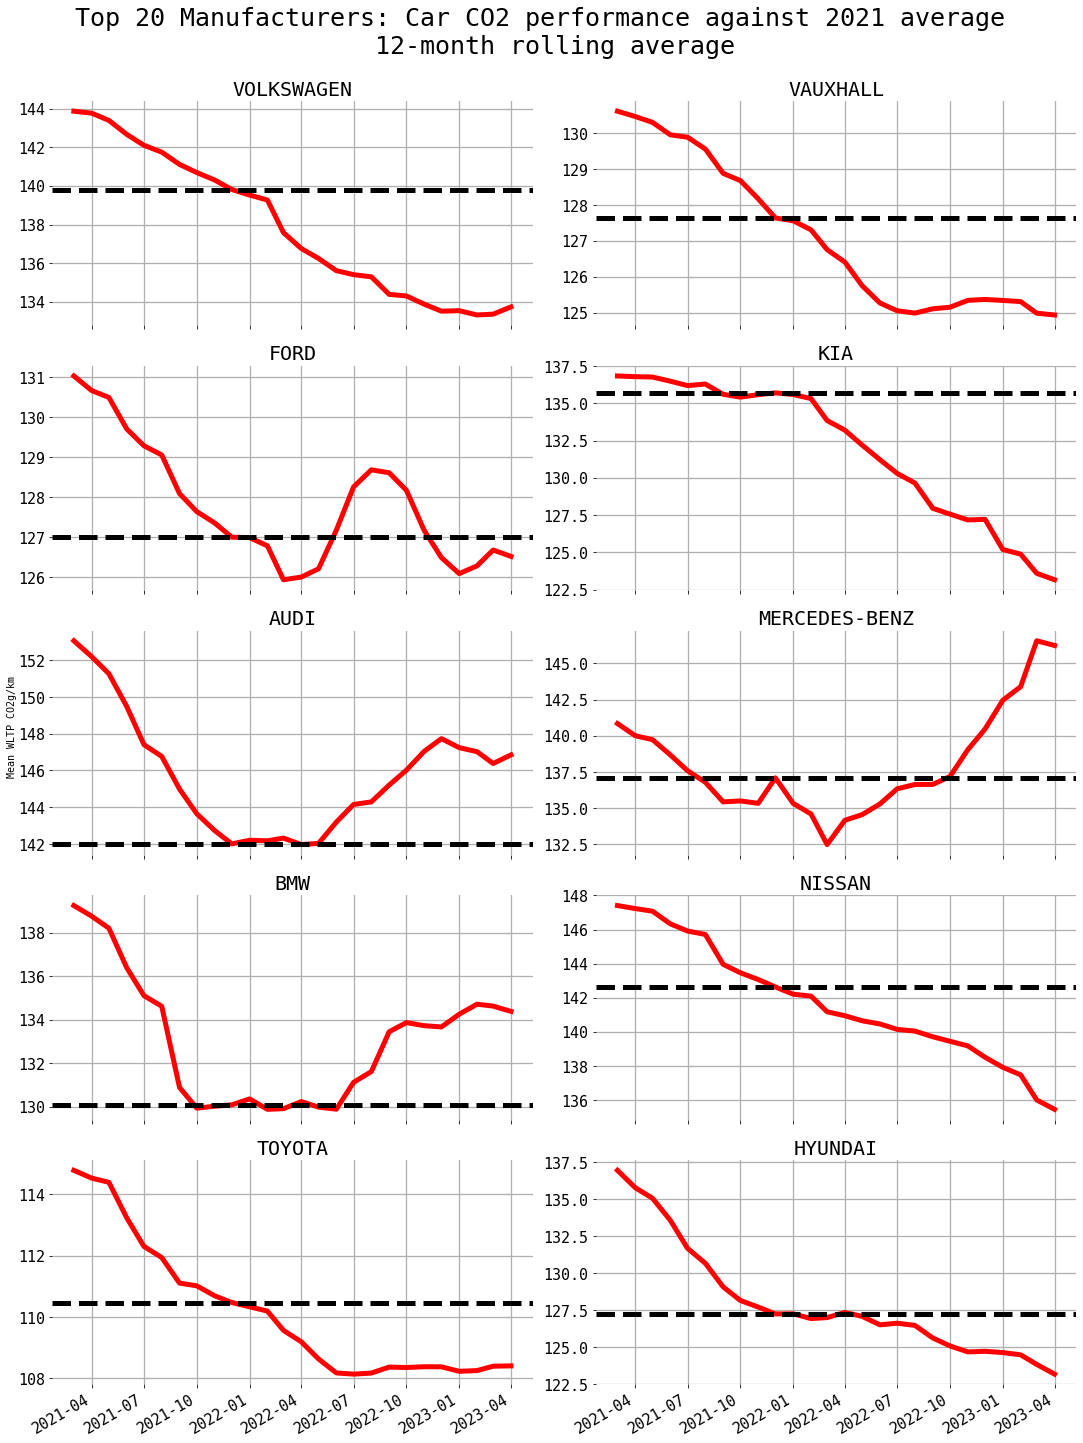

In [55]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))

# # df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes].plot(ax=ax)
# # ax.axhline(car_targets[car_targets.make.isin(top_makes)])
# # ax.set_xlabel('')
# # ax.legend(title='Make', loc='lower right')

plt_df = df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes]



for e, make in enumerate(top_makes[:5]):
    ax[e, 0].plot(plt_df[make], c='red')
    ax[e, 0].axhline(car_targets[car_targets.make == make].co2Target.values, c='black', linestyle='--')
    ax[e, 0].set_title(make)
    ax[e, 0].figure.autofmt_xdate()
    # ax[e, 0].set_ylabel('Mean WLPT CO2g/km')
    
for e, make in enumerate(top_makes[5:]):
    ax[e, 1].plot(plt_df[make], c='red')
    ax[e, 1].axhline(car_targets[car_targets.make == make].co2Target.values, c='black', label='2021 Baseline Target', linestyle='--')
    ax[e, 1].set_title(make)
    ax[e, 1].figure.autofmt_xdate()
    # ax[e, 1].set_ylabel('Mean WLPT CO2g/km')
    

fig.text(0.0, 0.5, 'Mean WLTP CO2g/km', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Top 20 Manufacturers: Car CO2 performance against 2021 average \n 12-month rolling average', y=1, fontsize=25)
fig.tight_layout()
# plt.show()

plt.savefig('plots/co2.png', transparent=False, bbox_inches='tight', dpi=300)

# ax[0, 0]

In [56]:
#A function to calculate CO2 flexibilities
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2ComplianceAdj > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits

In [57]:
targets = bq.from_bq_to_dataframe(
    query="""
    SELECT make, AVG(co2Emissions) as co2Target
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND monthOfFirstRegistration > '2020-12-31'
    AND monthOfFirstRegistration < '2022-01-01'
    AND co2Emissions > 0
    AND make IN (
        SELECT make
        FROM VES_dataset.VRN_UK
        WHERE typeApproval = 'M1'
        AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
        AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
        -- AND total >= 2500
        GROUP BY make
        HAVING COUNT(*) >= 2500
    )
    
    GROUP BY make
    """)

In [58]:
activity = bq.from_bq_to_dataframe(
    query = """
    SELECT 
        VES.make,
        VES.monthOfFirstRegistration,
        COUNT(*) as totalSales,
        COUNTIF(VES.co2Emissions > 0) as nonzevSales,
        COUNTIF(VES.co2Emissions = 0) as zevSales,
        SUM(VES.co2Emissions) as co2Activity

    FROM VES_dataset.VRN_UK VES
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    
    # Volume limit
    AND make IN (
        SELECT make
        FROM VES_dataset.VRN_UK
        WHERE typeApproval = 'M1'
        AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
        AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
        -- AND total > 2500
        GROUP BY make
        HAVING COUNT(*) > 2500
    )



    GROUP BY make, monthofFirstRegistration
    ORDER BY totalSales ASC;

    """

)

In [59]:
dfs = []
makes = activity.make.unique().tolist()

for make in makes:

    temp_df = activity[(activity.make == make)].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
activity = pd.concat(dfs)

In [60]:
# To calculate the CO2 flex that comes from rUK, we need to use the function above. We'll take a look at the whole of the UK's additional CO2 -> ZEV credits

ukevs = activity.groupby(['monthOfFirstRegistration', 'make']).sum().reset_index()

# First, we bring in the targets
ukevs = ukevs.merge(targets, how='left', on='make')

# then we calculate CO2 allowances
ukevs['co2Allowances'] = ukevs.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
ukevs['co2Compliance'] = ukevs.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

# How many available for transfer
ukevs['co2_to_mandate_allowances'] = ukevs.apply(lambda row: co2_to_zev(row, mandate=.22), axis=1)

# Then, the mandate
mandate = .22
ukevs['ZEVMallowances'] = ukevs.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
ukevs['ZEV Surplus'] = ukevs.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
ukevs['ZEV Surplus after CO2'] = ukevs.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)

ukevs['mean_co2'] = ukevs.co2Activity / ukevs.nonzevSales


AttributeError: 'Series' object has no attribute 'co2ComplianceAdj'

In [ ]:
len(ukevs.make.unique())

In [ ]:
nrows = 8
ncols = 4

list_list_makes = []


fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20, 40), sharex=True)

# myLocator = mticker.MultipleLocator(4)

rows = list(range(0, nrows))
columns = list(range(0, ncols))

counter = 0
for row in rows:
    for column in columns:
        try:
            # print(counter)
            make = makes[row::nrows][column]
            ax[row, column].plot(ukevs[ukevs.make == make].set_index('monthOfFirstRegistration').mean_co2, label='{} CO2 Wales Performance'.format(make))
            # ax[row, column].plot(ukevs[ukevs.make == make].set_index('monthOfFirstRegistration').mean_co2, label='{} CO2 rUK Performance'.format(make))
            ax[row, column].set_title(make)
            
            ax[row, column].axhline((targets[targets.make == make].co2Target.tolist()[0]), linestyle='dashdot', color='black', label='{} CO2 Target'.format(make))
            # ax[row, column].legend()
            # ax[row, column].xaxis.set_major_locator(myLocator)
        
        except Exception as e:
            print("Error with {m}: {e}".format(m=counter, e=e))
        
        counter += 1
    counter += 1    
    
# fig.legend()
fig.tight_layout()

# plt.savefig('plots/wales_uk_co2.png', transparent=True, bbox_inches='tight', dpi=300)

## Carbon rating of new cars & vans

In [ ]:
%%bigquery c2r --project rugged-baton-283921
SELECT monthOfFirstRegistration, fuelType, AVG(co2Emissions) as meanCo2
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'

AND fuelType IN ('PETROL', 'DIESEL', 'HYBRID ELECTRIC')
AND monthOfFirstRegistration > '2020-04-01'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
GROUP BY monthOfFirstRegistration, FuelType

In [ ]:
# c2r['fuelType'] = c2r.fuelType.apply(ft_cleaner)

In [ ]:
c2r['monthOfFirstRegistration'] = pd.to_datetime(c2r.monthOfFirstRegistration)
c2r = c2r.pivot(index='monthOfFirstRegistration', columns='fuelType', values='meanCo2')
c2r.columns = [x.title() for x in c2r.columns]

In [ ]:
fig, ax = plt.subplots()

c2r.plot(ax=ax)

ax.set_title('Monthly Mean CO2 Rating of New Cars by Fuel Type to {}'.format(last_month))
ax.set_ylabel('WLTP gCO2/km Rating')
ax.set_xlabel('Month of Registration')

plt.savefig('plots/mean_co2_fueltype_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, facecolor='white')

In [ ]:
%%bigquery wei --project rugged-baton-283921
SELECT monthOfFirstRegistration, fuelType, AVG(revenueWeight) as meanCo2
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'

AND fuelType IN ('PETROL', 'DIESEL', 'HYBRID ELECTRIC', 'ELECTRICITY')
AND monthOfFirstRegistration > '2020-04-01'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
GROUP BY monthOfFirstRegistration, FuelType

In [ ]:
wei['monthOfFirstRegistration'] = pd.to_datetime(wei.monthOfFirstRegistration)
wei = wei.pivot(index='monthOfFirstRegistration', columns='fuelType', values='meanCo2')
wei.columns = [x.title() for x in wei.columns]

In [ ]:
fig, ax = plt.subplots(2, figsize=(10, 10))

c2r.plot(ax=ax[0])
wei.plot(ax=ax[1])

ax[0].set_title('Monthly Mean CO2 Rating of New Cars by Fuel Type to {}'.format(last_month))
ax[0].set_ylabel('WLTP gCO2/km Rating')
ax[0].set_xlabel('Month of Registration')

ax[1].set_title('Monthly Mean Revenue Weight of New Cars by Fuel Type to {}'.format(last_month))
ax[1].set_ylabel('Revenue Weight (kg)')
ax[1].set_xlabel('Month of Registration')

plt.savefig('plots/mean_co2_fueltype_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, facecolor='white')